## Text-Based Ad Feedback Topic Modeling: Preprocessing

### TOC
* [Step 1: Load Data & Packages](#1)
* [Step 2: Tokenize & Remove Stopwords](#2)
* [Step 3: Lemmatization](#3)
* [Step 4: Create Dataframes for Modeling](#4)
* [Step 5: Term Frequency Analysis](#5)
* [Step 6: Create Vectorizer Object](#6)
* [Step 7: Train Test Split](#7)
* [Step 8: Save Processed Data](#8)

### Step 1: Load Data & Packages<a class="anchor" id="1"></a>

In [195]:
#Import Packages
import numpy as np 
import pandas as pd
import qgrid
def view(df_test):
    return qgrid.show_grid(df_test, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
import spacy
import en_core_web_sm
from spacy.tokenizer import Tokenizer
import gensim
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pickle

In [196]:
#Open data
clean_df = pd.read_csv('../Datafiles/Feedback_df_clean.csv')

In [197]:
#Explore data again
clean_df.head()

,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean
0,R_31EnmC82PmXgfeJ,A lot of chemicals are in vapes that damage th...,DF,17,White Only,1,1,0,1,a lot of chemicals are in vapes that damage th...
1,R_2UVKzhgLoqvkyzk,A method of discouragement against vaping by i...,DD,18,White Only,4,0,0,0,a method of discouragement against vaping by i...
2,R_2PC3MSRmAF3ln2c,About the ingredients in vape,ST,18,White Only,1,1,1,0,about the ingredients in vape
3,R_2X1neYEGvSteyEY,about the stuff that's in the vape juice,ST,17,White Only,5,1,1,0,about the stuff that is in the vape juice
4,R_2rMIp9IjjI6Mzpi,Ads at vape stores are misleading. It makes yo...,ST,18,Two or More - Non Hispanic,4,1,1,0,ads at vape stores are misleading it makes yo...


### Step 2: Tokenize & Remove Stopwords<a class="anchor" id="2"></a>
Source: Code adapted from a Towards Data Science article posted by Amin Azad at https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2, retrieved in January 2021.

In [198]:
#Load Spacy Stopwords

# Load spacy
nlp = en_core_web_sm.load()

#Stop words from spacy
STOP_WORDS = nlp.Defaults.stop_words

#### Running Tokenizer: 
* Decided to keep vape in and allow the CountVectorizer to filter out if exceeds threshold

In [199]:
# Tokenizer - Excluding 'none','nothing', and 'not'
tokenizer = Tokenizer(nlp.vocab)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)

tokens = []

for doc in tokenizer.pipe(clean_df['Text_Clean'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in ALL_STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
clean_df['Tokens'] = tokens

In [200]:
#Sort to see if any data was lost
clean_df = clean_df.sort_values(by='Tokens')

#Review results -- use tail because first few will be blank
clean_df.tail()

,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens
1443,R_1NtzYydKbITQGGx,young adults who vape are more susceptible to ...,DF,17,White Only,6,0,1,1,young adults who vape are more susceptible to ...,"[young, adults, vape, susceptible, viruses, to..."
202,R_29aWDCUPIEKWLHu,"Even if you are young and healthy, vaping can ...",DF,18,Two or More - Non Hispanic,4,1,1,1,even if you are young and healthy vaping can ...,"[young, healthy, , vaping, susceptible, healt..."
1444,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,18,White Only,1,0,1,0,young people should not be addicted to vapes,"[young, people, addicted, vapes]"
201,R_2q9Kw3MpcWPSx2Z,"Even as a young person, you can be more succep...",DF,18,Black Only,4,1,1,0,even as a young person you can be more succep...,"[young, person, , succeptible, infectious, di..."
1445,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,18,White Only,5,0,0,1,younger people need to stop being fooled comp...,"[younger, people, need, stop, fooled, , compa..."


### Step 3: Lemmatization <a class="anchor" id="3"></a>
For consistency, will use Spacy lemmatization.<br>

In [201]:
#Make tokens a string again
clean_df['Tokens_String'] = [' '.join(map(str, l)) for l in clean_df['Tokens']]

#Some tokens are just spaces now because of the remove of stopwords, so need to remove extra spaces
strings = [" ".join(i.split()) for i in clean_df['Tokens_String']]
    
#Update 'Tokens_String' to new list of strings without extra spaces
clean_df['Tokens_String'] = strings

Source: Spacy Lemmatization Code adapted from a Towards Data Science article posted by Amin Azad at https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2, retrieved in January 2021.

In [202]:
#Lemmatize
def get_lemmas(text):
    '''Used to lemmatize the processed tokens'''    
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

clean_df['Lemma_Tokens'] = clean_df['Tokens_String'].apply(get_lemmas)

In [203]:
#Review results -- use tail because first few will be blank
clean_df.tail()

,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Tokens_String,Lemma_Tokens
1443,R_1NtzYydKbITQGGx,young adults who vape are more susceptible to ...,DF,17,White Only,6,0,1,1,young adults who vape are more susceptible to ...,"[young, adults, vape, susceptible, viruses, to...",young adults vape susceptible viruses tough ad...,"[young, adult, vape, susceptible, virus, tough..."
202,R_29aWDCUPIEKWLHu,"Even if you are young and healthy, vaping can ...",DF,18,Two or More - Non Hispanic,4,1,1,1,even if you are young and healthy vaping can ...,"[young, healthy, , vaping, susceptible, healt...",young healthy vaping susceptible health issues,"[young, healthy, vape, susceptible, health, is..."
1444,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,18,White Only,1,0,1,0,young people should not be addicted to vapes,"[young, people, addicted, vapes]",young people addicted vapes,"[young, people, addicted, vape]"
201,R_2q9Kw3MpcWPSx2Z,"Even as a young person, you can be more succep...",DF,18,Black Only,4,1,1,0,even as a young person you can be more succep...,"[young, person, , succeptible, infectious, di...",young person succeptible infectious diseases s...,"[young, person, succeptible, infectious, disea..."
1445,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,18,White Only,5,0,0,1,younger people need to stop being fooled comp...,"[younger, people, need, stop, fooled, , compa...",younger people need stop fooled companies targ...,"[young, people, need, stop, fool, company, tar..."


In [204]:
# Make lemmas a string again
clean_df['Lemmas_String'] = [' '.join(map(str, l)) for l in clean_df['Lemma_Tokens']]

#Delete 'Tokens_String' because we will be using 'Lemmas_String' moving forward
clean_df = clean_df.drop(columns = ['Tokens_String'])

In [205]:
#Review results -- use tail because first few will be blank
clean_df.tail()

,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
1443,R_1NtzYydKbITQGGx,young adults who vape are more susceptible to ...,DF,17,White Only,6,0,1,1,young adults who vape are more susceptible to ...,"[young, adults, vape, susceptible, viruses, to...","[young, adult, vape, susceptible, virus, tough...",young adult vape susceptible virus tough adult...
202,R_29aWDCUPIEKWLHu,"Even if you are young and healthy, vaping can ...",DF,18,Two or More - Non Hispanic,4,1,1,1,even if you are young and healthy vaping can ...,"[young, healthy, , vaping, susceptible, healt...","[young, healthy, vape, susceptible, health, is...",young healthy vape susceptible health issue
1444,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,18,White Only,1,0,1,0,young people should not be addicted to vapes,"[young, people, addicted, vapes]","[young, people, addicted, vape]",young people addicted vape
201,R_2q9Kw3MpcWPSx2Z,"Even as a young person, you can be more succep...",DF,18,Black Only,4,1,1,0,even as a young person you can be more succep...,"[young, person, , succeptible, infectious, di...","[young, person, succeptible, infectious, disea...",young person succeptible infectious disease sm...
1445,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,18,White Only,5,0,0,1,younger people need to stop being fooled comp...,"[younger, people, need, stop, fooled, , compa...","[young, people, need, stop, fool, company, tar...",young people need stop fool company target you...


### Step 4: Create Dataframes for Modeling <a class="anchor" id="4"></a>

In [206]:
#Remove blanks from sample and create new 'processed_df' for modeling
clean_df['Lemmas_String'] = clean_df['Lemmas_String'].str.strip()
processed_df = clean_df[clean_df['Lemmas_String']!=""]

In [207]:
#Now that the df is filtered, reset index as well
processed_df = processed_df.reset_index().drop(columns='index').copy()

In [208]:
#Review results
print('\033[1m' + 'clean_df Shape'+'\033[0m')
print(clean_df.shape)
print('\033[1m' + 'processed_df Shape'+'\033[0m')
print(processed_df.shape)
print('\033[1m' + 'View processed_df'+'\033[0m')
processed_df.head()

clean_df Shape
(1448, 13)
processed_df Shape
(1439, 13)
View processed_df


,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
0,R_w5eD956UhK9krDz,"To me, the main message of this ad is trying t...",DF,16,Black Only,5,1,1,0,to me the main message of this ad is trying t...,"[ , main, message, ad, trying, tell, smoking, ...","[main, message, ad, try, tell, smoke, time, fl...",main message ad try tell smoke time flu season...
1,R_UnnyfHhm6BP8r4Z,"Again, to scare teens from vaping.",DF,17,White Only,1,0,1,0,again to scare teens from vaping,"[ , scare, teens, vaping]","[scare, teen, vape]",scare teen vape
2,R_w5eD956UhK9krDz,"That we, teens are letting a company get to us...",DD,16,Black Only,5,1,1,0,that we teens are letting a company get to us...,"[ , teens, letting, company, money, time, teen...","[teen, let, company, money, time, teen, buy, l...",teen let company money time teen buy legally s...
3,R_3FIpTKOmcDDNAf5,"The ""water vapors"" from the vape isnt water va...",ST,18,White Only,1,0,1,1,the water vapors from the vape is not water ...,"[ , water, vapors, , vape, water, vapors, , ...","[water, vapor, vape, water, vapor, atleast, 31...",water vapor vape water vapor atleast 31 chemic...
4,R_3COzYGzgMssUgSF,We dont actually know what the chemicals in th...,ST,18,White Only,4,0,1,0,we do not actually know what the chemicals in ...,"[actually, know, chemicals, vapes, bodies]","[actually, know, chemical, vape, body]",actually know chemical vape body


### Step 5: Check Term Frequency Again <a class="anchor" id="5"></a>

#### Main Message Feedback Text Frequency

Source: Term Frequency Analysis and WordCloud code adapted from Towards Data Science article by Kamil Mysiak at 
https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d retrieved in January, 2021.

In [209]:
#Create word list
words = processed_df['Lemma_Tokens']
allwords = []
for wordlist in words:
    allwords += wordlist

In [210]:
#Create function for word frequency bar plots
color_palette = ['midnightblue','#24478f','steelblue','#7FB3D5','skyblue','#b3e0ff'] 
def word_bar(x,y,figsize,colors):
    #Loop below creates the percentage labels
    y_percents = []
    for i in y:
        y_percents.append((round((i / (np.sum(y))) *100,1)))
    
    y_perlabs = []
    for i in y_percents: 
        y_perlabs.append(str(i)+'%')
    y_perlabs = np.array(y_perlabs)
    
    x = x
    
    plt.subplots(figsize=figsize)
    plt.bar(x, y, align='center', color=colors) #actual bar plot setup
    plt.xticks(rotation=60)


    # Text on the top of each bar, 
    # Code for below adapted from https://www.python-graph-gallery.com/10-barplot-with-number-of-observation
    for i in range(len(x)):
        plt.text(x = x[i] , y = y[i]+0.5, s=y_perlabs[i])

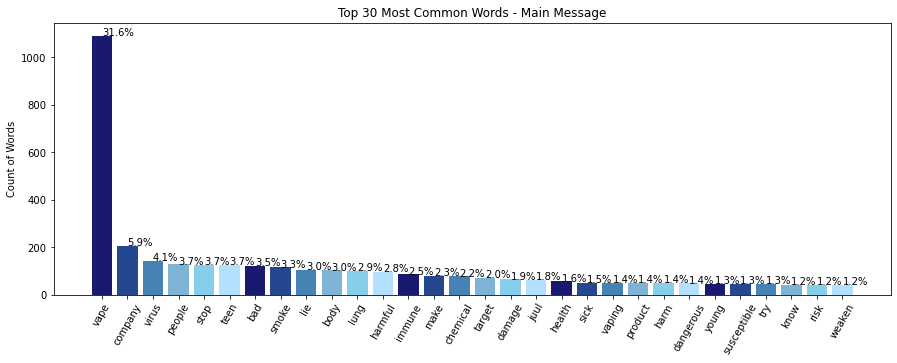

In [211]:
mostcommon_small = FreqDist(allwords).most_common(30)
x, y = zip(*mostcommon_small)
        
word_bar(x,y,(15,5),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Top 30 Most Common Words - Main Message')
plt.ylabel('Count of Words')
plt.show()

#### Notes:
* 'Vape' may be filtered out of topics when word vectors are created.

### Step 6: Create TF-IDF Vectorizer<a class="anchor" id="6"></a> 

Term Frequency - Inverse Document Frequency (TF-IDF)<br>
Creates a vectorizer object where terms are weighted so that frequent terms that do not have meaningful information are weighted down and terms that are infrequent but provide meaningful information are weighted up. <br>
(Information sourced from 'Hands-On Python Natural Language Processing. by Aman Kedia and Mayank Rasu, pp. 84) <br>

* The following parameters may need to be optimized, rest will use default
    * ngram_range: this will actually be set to default = 1 to start because each response is only one or two sentences long
    * max_df: excludes words that occur more frequently than max threshold (if float is %)
    * min_df: excludes words that occur less frequently than min threshold (if float is %)
    * max_features: this is another method for excluding infrequent words, so don't need to set if setting max_df, min_df

In [212]:
#Pull words list for training set to inform parameter selection
words = processed_df['Lemma_Tokens']
allwords = []
for wordlist in words:
    allwords += wordlist
    
#Get total count of unique words
print('The processed corpus contains ' + str(len(set(allwords))) + ' unique words.')

#Get idea of count for max df
print('A word would need to appear more than ' + str(len(set(allwords))*.95) + ' times to be excluded at 95% max threshold.')

The processed corpus contains 750 unique words.
A word would need to appear more than 712.5 times to be excluded at 95% max threshold.


In [213]:
#Get list of max_df words to be excluded
max_excluded_words = [str(i[0]) + ": "+ str(i[1]) for i in FreqDist(allwords).most_common() 
                  if i[1] > (len(set(allwords))*.95)]

#Get a count of words that will be excluded at maximum threshold
print(str(len(max_excluded_words)) + ' word/s will be excluded at max threshold')

#Show list
print(max_excluded_words)

1 word/s will be excluded at max threshold
['vape: 1090']


In [214]:
#Get list of min_df words to be excluded
min_excluded_words = [str(i[0]) + ": "+ str(i[1]) for i in FreqDist(allwords).most_common() 
                  if i[1] < 2]

#Get count of words that will be excluded at min threshold
print(str(len(min_excluded_words)) + ' word/s will be excluded at min threshold')

403 word/s will be excluded at min threshold


Source: tfidf_vectorizer code adapted from Towards Data Science article by Kamil Mysiak at https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d retrieved in January, 2021.

In [215]:
#Create vectorizer object
#Max_df: Filter out words that appear in more than 95% of feedback
#Min_df: Filter out words that appear less than 2 times

#Instantiate vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, use_idf=True)

#Create matrix as result of fit_transform() on feedback training set
tfidf = tfidf_vectorizer.fit_transform(processed_df['Lemmas_String'].values.astype('U'))
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#Create df from the matrix to view
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(),columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,19,ability,actively,actually,ad,add,addict,addicted,addiction,addictive,...,water,way,weak,weaken,wear,website,world,wrong,young,youth
0,0.0,0.0,0.0,0.000000,0.276071,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.695104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.645629,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.305956,0.0
1435,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.378932,0.0
1436,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.677058,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.564697,0.0
1437,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262349,0.0


In [216]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tfidf_test, tfidf_vectorizer,mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       1.465019 -47.625065       1        1  20.031085
3      54.854797 -36.476795       2        1  19.688474
4      32.212929 -61.444572       3        1  19.567510
5       5.111096 -14.110332       4        1  16.214834
2      26.350170 -33.374702       5        1  12.530440
1      38.109818  -7.222781       6        1  11.967656, topic_info=        Term       Freq      Total Category  logprob  loglift
273    smoke  21.000000  21.000000  Default  30.0000  30.0000
281     stop  20.000000  20.000000  Default  29.0000  29.0000
28       bad  19.000000  19.000000  Default  28.0000  28.0000
58   company  16.000000  16.000000  Default  27.0000  27.0000
291     teen  11.000000  11.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
28       bad   2.892807  19.409569   Topic6  -3.4506   0.2194
215   people   1.851828  16.257125   Topic6  -3.8967  -0.0494
319     vape   3.368446  69.950350   Topic6  -3.2984  -0.9104
136   health   0.881041   8.913337   Topic6  -4.6395  -0.1912
204    money   0.616913   2.357992   Topic6  -4.9959   0.7821

[273 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         2  0.723370        19
1         3  0.988852   ability
3         1  0.757465  actually
4         6  0.654488        ad
6         1  0.977333    addict
...     ...       ...       ...
336       3  0.667013      wear
338       3  0.842447     world
340       1  0.751330     young
340       3  0.150266     young
340       4  0.150266     young

[236 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 6, 3, 2])

### Step 7: Train-Test Split<a class="anchor" id="7"></a> 
Typically splitting the data into training & test sets is not necessary for unsupervised learning. However, because hyper-parameter tuning will be needed for topic modeling, it is best to split the data so that 'unseen' data is not used in optimization.

In [217]:
#View ad distribution to see if stratification is needed

print("\033[1m"+'Number of Cases in Message df:'+"\033[0;0m")
print(processed_df.shape[0])
print("\033[1m"+'Percentage\n'+"\033[0;0m"+str(round(processed_df['Ad'].value_counts(normalize=True),2)*100))

Number of Cases in Message df:
1439
Percentage
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


#### Notes: 
* Text feedback is not balanced across ads, so need to stratify the train-test split by ad in order to ensure the train and test data reflect a similar distribution of ads.
* Will split with X being index of processed_df to split df and vectorizer object

In [218]:
#Conduct train test split (just with X because this is unsupervised) and stratify by ad
#Using 70% train, 30% test to ensure about 1000 training cases
#Using index in order to create full train and test dfs

X_train, X_test = train_test_split(processed_df.index, stratify=processed_df['Ad'], test_size=0.3, random_state=22)

In [219]:
#Create the training df for message
df_train = processed_df.iloc[X_train]
#Create the test df for message
df_test = processed_df.iloc[X_test]

In [220]:
#Create the training vectorizer
tfidf_train = tfidf[X_train]

#Create the test vectorizer
tfidf_test = tfidf[X_test]

In [221]:
#Check work
print("\033[1m"+'Training df n:'+"\033[0;0m")
print(df_train.shape[0])
print("\033[1m"+'Training vector shape:'+"\033[0;0m")
print(tfidf_train.shape[0])
print("\033[1m"+'Testing df Ad Distribution:'+"\033[0;0m")
print(str(round(df_train['Ad'].value_counts(normalize=True),2)*100))

Training df n:
1007
Training vector shape:
1007
Testing df Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


In [222]:
#Check work
print("\033[1m"+'Test df for Message n:'+"\033[0;0m")
print(df_test.shape[0])
print("\033[1m"+'Test vector shape:'+"\033[0;0m")
print(tfidf_test.shape[0])
print("\033[1m"+'Test df for Message Ad Distribution:'+"\033[0;0m")
print(str(round(df_test['Ad'].value_counts(normalize=True),2)*100))

Test df for Message n:
432
Test vector shape:
432
Test df for Message Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


### Step 8: Save Processed Data<a class="anchor" id="8"></a> 
* Save to pickle to maintain df var types

In [224]:
#Save df test to pickle.
processed_df.to_pickle('../Datafiles/processed_df.pkl')

#Save df test to pickle.
df_train.to_pickle('../Datafiles/df_train.pkl')

#Save df test to pickle.
df_test.to_pickle('../Datafiles/df_test.pkl')

#Save tfidf train to pickle.
file_name = '../Datafiles/tfidf_train.pkl'

open_file = open(file_name, "wb")
pickle.dump(tfidf_train, open_file)
open_file.close()

#Save tfidf test to pickle.
file_name2 = '../Datafiles/tfidf_test.pkl'

open_file = open(file_name2, "wb")
pickle.dump(tfidf_test, open_file)
open_file.close()

#Save tfidf feature names to pickle.
file_name3 = '../Datafiles/tfidf_feature_names.pkl'

open_file = open(file_name3, "wb")
pickle.dump(tfidf_feature_names, open_file)
open_file.close()